In [1]:
import pandas as pd
import numpy as np
import torch

import sys
sys.path.insert(1, '../')
import data_handler

/storagenfs/m.melerocavallo/HLTKeyPointAnalysis/venv2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device(2)

# Data Management

In [4]:
df_train, df_val, df_test = data_handler.load_full_dataset('../dataset/', get_train=True, get_dev=True, get_test=True)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24093 entries, 0 to 3457
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   argument   24093 non-null  object
 1   key_point  24093 non-null  object
 2   topic      24093 non-null  object
 3   stance     24093 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 941.1+ KB


In [6]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3426 entries, 0 to 3425
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   argument   3426 non-null   object
 1   key_point  3426 non-null   object
 2   topic      3426 non-null   object
 3   stance     3426 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 107.2+ KB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   argument  18398 non-null  object
 1   topic     18398 non-null  object
 2   stance    18398 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 431.3+ KB


In [8]:
print(f"Number of unique topics present in Training set: {len(df_train['topic'].unique())}")
print(f"Number of unique topics present in Validation set: {len(df_val['topic'].unique())}")
print(f"Number of unique topics present in Test set: {len(df_test['topic'].unique())}")

Number of unique topics present in Training set: 28
Number of unique topics present in Validation set: 3
Number of unique topics present in Test set: 43


In [9]:
#Check if there are some shared topics
print(f"Overlap of topics between Training and Validation: {len(np.intersect1d(df_train['topic'].unique(), df_val['topic'].unique()))}")
print(f"Overlap of topics between Training and Test: {len(np.intersect1d(df_train['topic'].unique(), df_test['topic'].unique()))}")
print(f"Overlap of topics between Test and Validation: {len(np.intersect1d(df_val['topic'].unique(), df_test['topic'].unique()))}")

Overlap of topics between Training and Validation: 0
Overlap of topics between Training and Test: 0
Overlap of topics between Test and Validation: 0


In [10]:
# Concatenate topics and keypoints, as stated in the paper
df_train = data_handler.concatenate_topics(df_train, input_col='argument', output_col='argument')
df_val = data_handler.concatenate_topics(df_val, input_col='argument', output_col='argument')
df_test = data_handler.concatenate_topics(df_test, input_col='argument', output_col='argument')

In [11]:
n_words = pd.DataFrame()
n_words['words_per_arg_train'] = df_train['argument'].str.split().apply(len)
n_words['words_per_arg_val'] = df_val['argument'].str.split().apply(len)
n_words['words_per_arg_test'] = df_test['argument'].str.split().apply(len)

<AxesSubplot: >

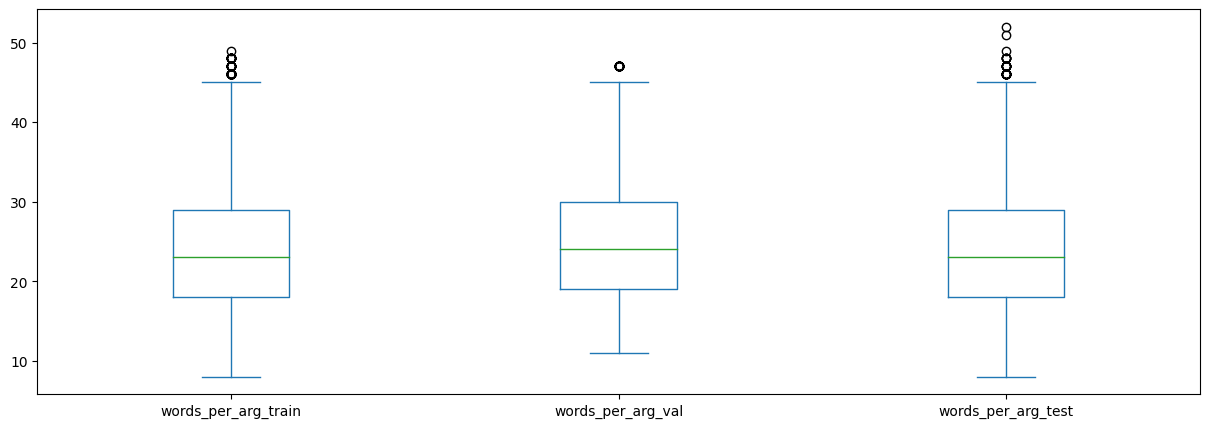

In [12]:
n_words.plot.box(figsize=(15, 5))

In [13]:
print(f"Max number of words for Training args: {n_words['words_per_arg_train'].max()}")
print(f"Max number of words for Validation args: {n_words['words_per_arg_val'].max()}")
print(f"Max number of words for Test args: {n_words['words_per_arg_test'].max()}\n")

Max number of words for Training args: 49
Max number of words for Validation args: 47.0
Max number of words for Test args: 52.0



In [14]:
def tokenization_target(sentences, tokenizer, max_length=512):
     # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []
        attention_masks = []

      # For every sentence...
        with tokenizer.as_target_tokenizer():
            for sent in sentences:
              # `encode_plus` will:
              #   (1) Tokenize the sentence.
              #   (2) Prepend the `[CLS]` token to the start.
              #   (3) Append the `[SEP]` token to the end.
              #   (4) Map tokens to their IDs.
              #   (5) Pad or truncate the sentence to `max_length`
              #   (6) Create attention masks for [PAD] tokens.
                encoding = tokenizer.encode_plus(
                                  sent,                      # Sentence to encode.
                                  add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                  max_length = max_length,   # Pad & truncate all sentences.
                                  pad_to_max_length = True,
                                  return_attention_mask = True,   # Construct attn. masks.
                                  return_tensors = 'pt',     # Return pytorch tensors.
                                  truncation=True
                            )

              # Add the encoded sentence to the list.    
                input_ids.append(encoding['input_ids'])

              # And its attention mask (simply differentiates padding from non-padding).
                attention_masks.append(encoding['attention_mask'])

      # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        return input_ids, attention_masks

In [15]:
def tokenize_df_gen(df, tokenizer, max_length=512):
    input_id_args, attention_masks_args = tokenization(df['argument'], tokenizer, max_length=max_length)
    input_id_kps, attention_masks_kps = tokenization_target(df['key_point'], tokenizer, max_length=max_length)

    tokenized = [ { 'id': i,
        'argument':{
            'input_ids': input_id_args[i],
            'attention_masks' : attention_masks_args[i]
            }, 
            'kp':{
                'input_ids': input_id_kps[i],
                'attention_masks' : attention_masks_kps[i]
            }} for i in range(len(input_id_args)) ]

    return tokenized

In [18]:
from data_handler import tokenization
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('google/pegasus-xsum')
tokenized_tr = tokenize_df_gen(df_val, tokenizer, max_length=60)

Downloading: 100%|███████████████████████████████████████████████████████████████████| 87.0/87.0 [00:00<00:00, 58.1kB/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████| 1.39k/1.39k [00:00<00:00, 632kB/s]
Downloading: 100%|█████████████████████████████████████████████████████████████████| 1.91M/1.91M [00:01<00:00, 1.70MB/s]
Downloading: 100%|█████████████████████████████████████████████████████████████████| 3.52M/3.52M [00:01<00:00, 2.03MB/s]
Downloading: 100%|███████████████████████████████████████████████████████████████████| 65.0/65.0 [00:00<00:00, 24.7kB/s]
/storagenfs/m.melerocavallo/HLTKeyPointAnalysis/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can g

In [19]:
tokenized_tr

[{'id': 0,
  'argument': {'input_ids': tensor([40258,   667, 28358,   246,   129,  7672, 40258,  4441, 28358,   246,
             129,  7672,   118,  5807,  5498,     1,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
   'attention_masks': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])},
  'kp': {'input_ids': tensor([40258,   667, 28358,   127,   957,     1,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0, 

In [17]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")

axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

NameError: name 'dataset_samsum' is not defined